In [1]:
# =============================================================================
# NOTEBOOK SETUP - Two Population Delay Sweep Execution
# =============================================================================
import os
import sys
from pathlib import Path
from brian2 import *

# Robust directory setup
if Path.cwd().name == 'two_populations':
    os.chdir("../../")

from src.two_populations.helpers.logger import setup_logger

logger = setup_logger(
    experiment_name="test_delays",
    console_level="DEBUG",
    log_to_file=False
)


logger.info(f"Working directory: {Path.cwd()}")
logger.info(f"Python path: {sys.path[0]}")

/home/ubuntu-deduce/Projects/izhikevich/.venv/lib/python3.10/site-packages/setuptools/_distutils/_msvccompiler.py:12: UserWarning: _get_vc_env is private; find an alternative (pypa/distutils#340)
  warnings.warn(
INFO       Cache size for target 'cython': 2683 MB.
You can call clear_cache('cython') to delete all files from the cache or manually delete files in the '/home/ubuntu-deduce/.cython/brian_extensions' directory. [brian2]
INFO     | __main__:<module>:22 - Working directory: /home/ubuntu-deduce/Projects/izhikevich
INFO     | __main__:<module>:23 - Python path: /home/ubuntu-deduce/.asdf/installs/python/3.10.13/lib/python310.zip


In [2]:
# =============================================================================
# SINGLE SIMULATION CONFIGURATION
# =============================================================================
import numpy as np
from src.two_populations.model import IzhikevichNetwork
from src.two_populations.metrics import analyze_simulation_results, print_network_statistics_table
from src.two_populations.plots.dashboard_plots import plot_connectivity_dashboard, plot_population_dashboard

# =============================================================================
# SINGLE SIMULATION WITH POISSON INPUT
# =============================================================================

inter_k_factor = 0.0
intra_delay = 0.0
p_intra = 0.1
Ni = 200
Ne = 800
time = 3000

SIM_CONFIG = {
    'dt_ms': 0.1,
    'T_ms': time,
    'warmup_ms': 500
}

#    'noise_exc': 0.455, 
#         'noise_inh': 0.262,
#         'p_intra': 0.1, 
#         'delay': 0.0,
#         'rate_hz':2.42*10, =13.80, w_exc=0.677, w_inh=0.385 → loss=0.565


# Parámetros simplificados para create_population2
NETWORK_PARAMS = {
    'pop_A': {
        'Ne': Ne, 'Ni': Ni,
        'k_exc': 1.0,
        'k_inh': 2.0,
        'noise_exc': 0.677, 
        'noise_inh': 0.385,
        'p_intra': 0.1, 
        'delay': 0.0,
        'rate_hz':13.80,
        'stim_base':1.0, 'stim_elevated':None,
        'stim_start_ms':None, 'stim_duration_ms':None
    },
    'pop_B': {
        'Ne': Ne, 'Ni': Ni,
        'k_exc': 1.0,
        'k_inh': 3.87,
        'noise_exc': 1.0, 
        'noise_inh': 0.6,
        'p_intra': 0.1, 
        'delay': 0.0,
        'rate_hz':10.0,
        'stim_base':1.0, 'stim_elevated':2.0,
        'stim_start_ms':1000, 'stim_duration_ms':500
    },
    'connection': {
        'p_inter': 0.02,
        'weight_scale': inter_k_factor * 1.0,
        'delay_dist': 'constant',
        'delay_params': {},
        'delay_value': 0.0
    }
}

logger.info("Simulation configured:")
logger.info(f"  Duration: {SIM_CONFIG['T_ms']}ms, dt: {SIM_CONFIG['dt_ms']}ms")
logger.info(f"  Inter-population delay: {NETWORK_PARAMS['connection']['delay_dist']}")


# Debug simplificado
def debug_poisson_input(network):
    for name in ['A', 'B']:
        pop = network.populations[name]
        G = pop['group']
        thalamic = pop['thalamic']
        
        print(f"\n=== Population {name} ===")
        print(f"PoissonInput: {thalamic}")
        print(f"Neurons: {len(G)}")
        print(f"g_exc inicial: min={min(G.g_exc)}, max={max(G.g_exc)}")

# =============================================================================
# RUN SINGLE SIMULATION
# =============================================================================
from src.two_populations.model import IzhikevichNetwork

start_scope()

network = IzhikevichNetwork(
    dt_val=SIM_CONFIG['dt_ms'],
    T_total=SIM_CONFIG['T_ms'],
    fixed_seed=100,
    variable_seed=200,
    trial=1
)

# Usar create_population2
pop_A = network.create_population2('A', **NETWORK_PARAMS['pop_A'])
pop_B = network.create_population2('B', **NETWORK_PARAMS['pop_B'])

# Connect populations
syn_AB = network.connect_populations('A', 'B', **NETWORK_PARAMS['connection'])

# Setup monitors and run
network.setup_monitors(['A', 'B'], record_v_dt=0.5, sample_fraction=0.5, monitor_conductance=True)

# debug_poisson_input(network)
results = network.run_simulation()


# Quick check
logger.info(f"\n{'='*50}")
logger.info("SIMULATION COMPLETED")
logger.info(f"{'='*50}")
logger.info(f"Population A: {len(results['A']['spike_times'])} spikes")
logger.info(f"Population B: {len(results['B']['spike_times'])} spikes")
logger.info(f"Recording shape: {results['A']['potentials'].shape}")
logger.info(f"\nSimulation completed (PoissonInput mode)")

INFO     | __main__:<module>:68 - Simulation configured:
INFO     | __main__:<module>:69 -   Duration: 3000ms, dt: 0.1ms
INFO     | __main__:<module>:70 -   Inter-population delay: constant
SUCCESS  | src.two_populations.model:__init__:44 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 203, 'variable_A_current': 203, 'variable_B_current': 206}
INFO     | src.two_populations.model:_create_stimulus2:327 - PoissonGroup A: 100 sources @ 13.8Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:262 - Population A (PoissonInput): 800E/200I, 79938+20213 syn
INFO     | src.two_populations.model:_create_stimulus2:327 - PoissonGroup B: 100 sources @ 10.0Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:262 - Population B (PoissonInput): 800E/200I, 80

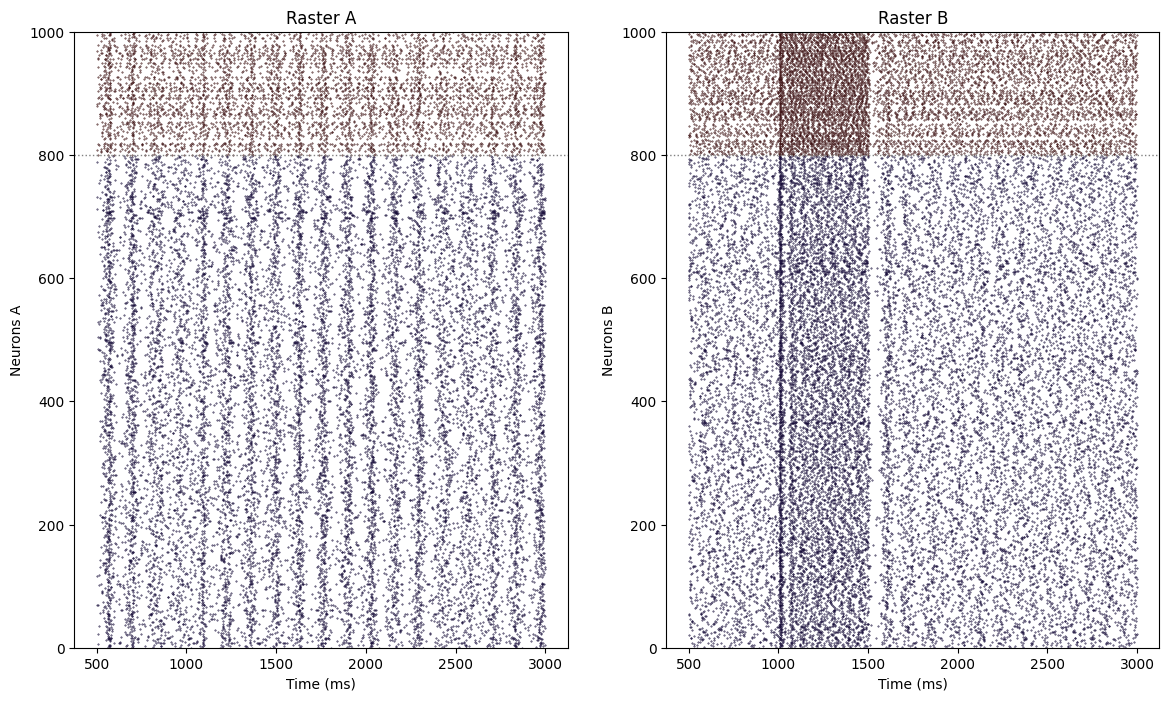

In [3]:
# =============================================================================
# ADDITIONAL ANALYSIS (Optional)
# =============================================================================

from src.two_populations.plots.basic_plots import plot_raster_results, plot_all_basic_analysis, plot_voltage_traces

fig = plot_raster_results(results)

INFO     | src.two_populations.metrics:analyze_simulation_results:561 - 
=== Baseline (lfp) ===
INFO     | src.two_populations.metrics:analyze_simulation_results:563 - Cross-corr: 0.120 @ -21.0ms
INFO     | src.two_populations.metrics:analyze_simulation_results:564 - Alpha PLV: 0.295, PLI: 0.051
INFO     | src.two_populations.metrics:analyze_simulation_results:565 - Coherence: 0.460 @ 68.4Hz
INFO     | src.two_populations.metrics:analyze_simulation_results:566 - Timescales: A=16.6ms, B=6.9ms


signal shape: (5000,)
has NaN: False
has inf: False
signal shape: (5000,)
has NaN: False
has inf: False


INFO     | src.two_populations.metrics:calculate_synchrony_metrics:642 -     DEBUG: CV_individual=0.390, CV_population=0.671
INFO     | src.two_populations.metrics:calculate_synchrony_metrics:642 -     DEBUG: CV_individual=0.335, CV_population=0.570
INFO     | src.two_populations.metrics:print_network_statistics_table:705 - 
INFO     | src.two_populations.metrics:print_network_statistics_table:707 - COMPARACIÓN ESTADÍSTICAS DE RED (Post-warmup 500ms)
INFO     | src.two_populations.metrics:print_network_statistics_table:708 - ================================================================================
INFO     | src.two_populations.metrics:print_network_statistics_table:710 - Métrica                   Población A               Población B              
INFO     | src.two_populations.metrics:print_network_statistics_table:711 - ---------------------------------------------------------------------------
INFO     | src.two_populations.metrics:print_network_statistics_table:720 - ARQUIT

baseline: 500 monitored, 400 exc
  Plotting: [np.int64(174), np.int64(501), np.int64(329), np.int64(801), np.int64(926), np.int64(970)]


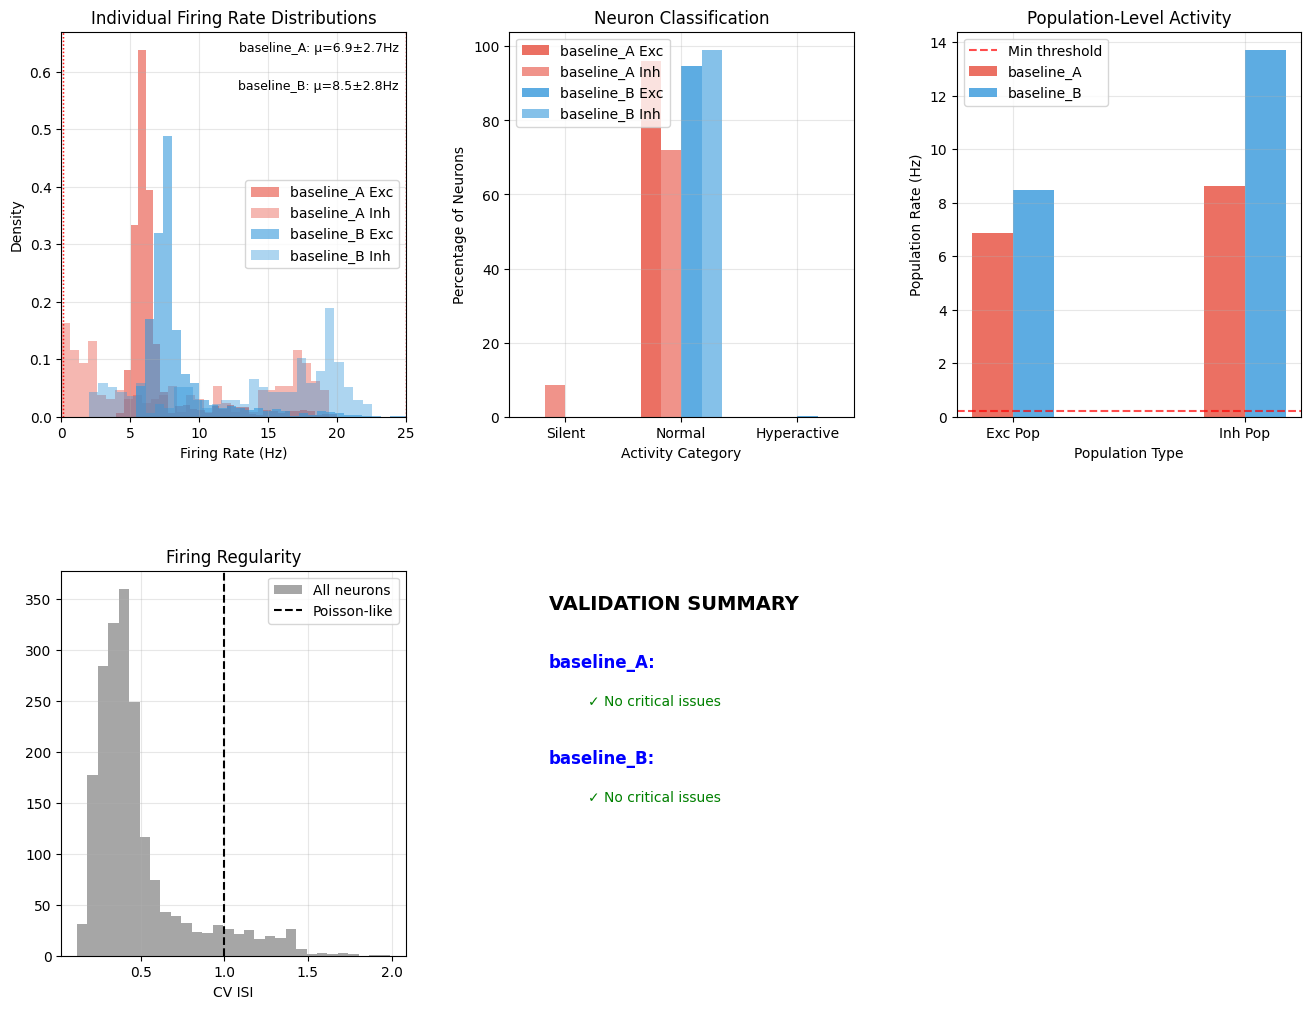

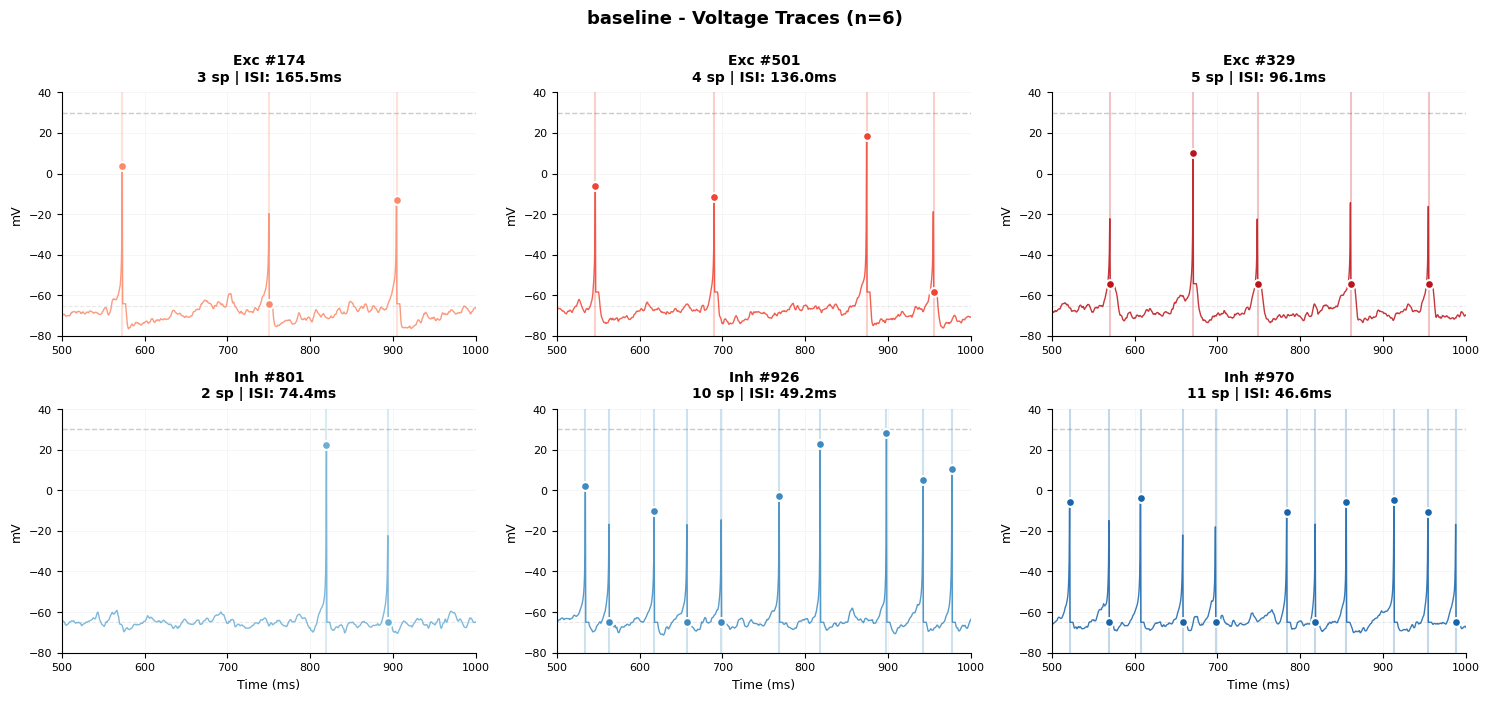

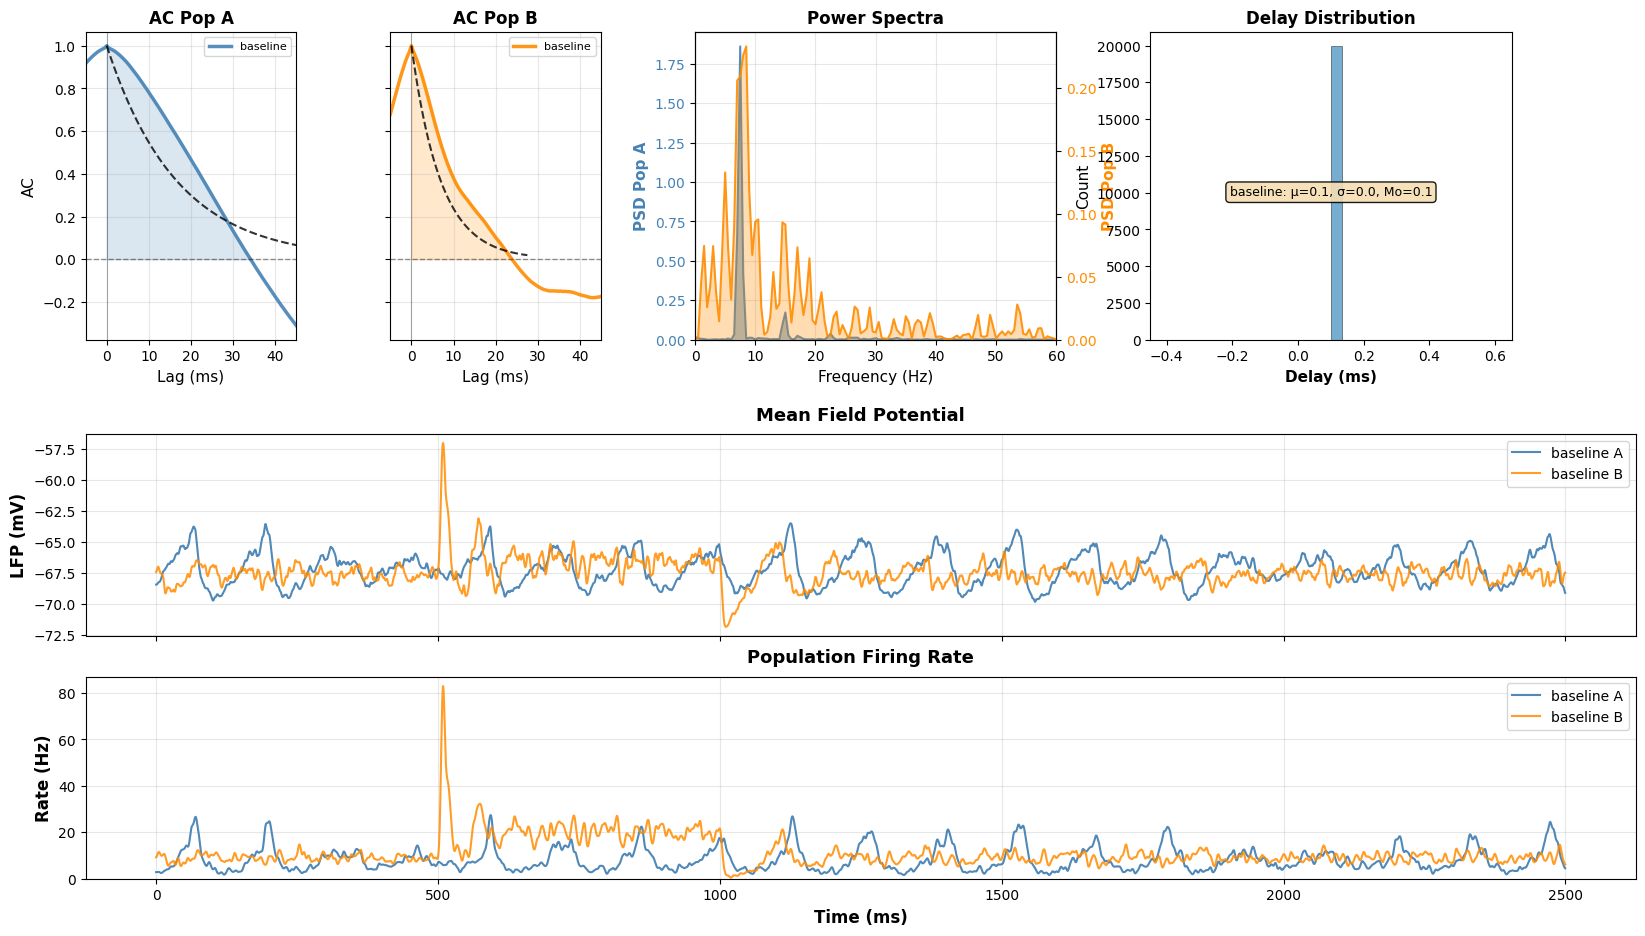

In [4]:
# =============================================================================
# ANALYSIS WITH VALIDATION
# =============================================================================
from src.two_populations.helpers.validator import (
    add_validation_to_analysis, 
    plot_population_validation_dashboard, 
    print_validation_summary
)
from src.two_populations.metrics import analyze_simulation_results

# Analyze connectivity
results_dict = {
    'baseline': analyze_simulation_results(
        results['A']['spike_monitor'], 
        results['B']['spike_monitor'], 
        Ne + Ni, "Baseline", 
        warmup=SIM_CONFIG['warmup_ms'],
        state_monitors={
                'A': network.monitors['A'],  # pasar dict completo
                'B': network.monitors['B']
        },
       delays = {'AB': np.array(results['delays_AB']), 'BA': None},
       signal_mode = 'lfp' # firing_rate
    )
}

# Add validation metrics<
validation_results = add_validation_to_analysis(results_dict)

# Network statistics table
print_network_statistics_table(
    results, network, 
    N_exc=Ne, N_inh=Ni, 
    T_total=SIM_CONFIG['T_ms'], 
    warmup=SIM_CONFIG['warmup_ms']
)

# Dashboards
fig_val = plot_population_validation_dashboard(validation_results)
print_validation_summary(validation_results)

fig = plot_voltage_traces(results_dict, results, (500,1000), 3,3,True,3)
fig_pop = plot_population_dashboard(results_dict)
plt.show()

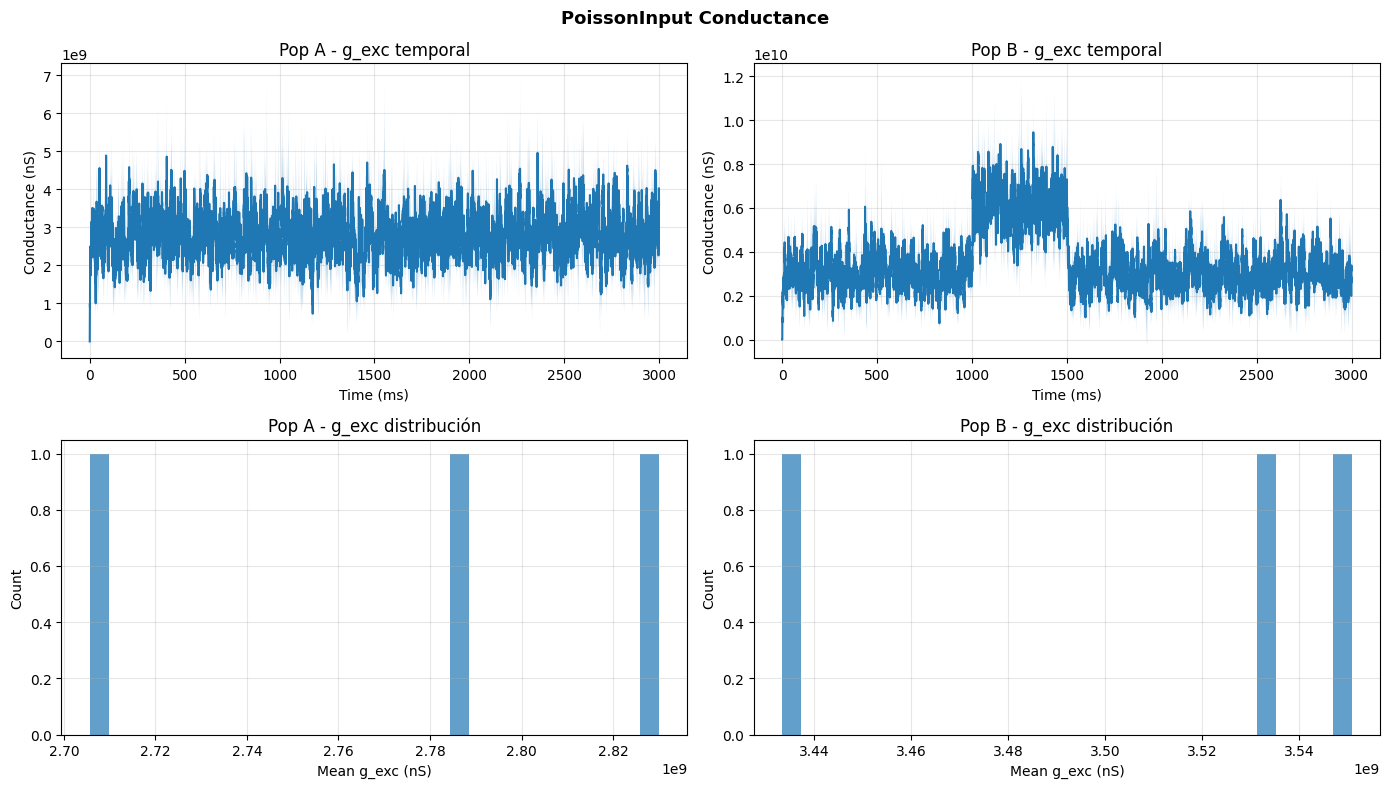

In [5]:
from src.two_populations.plots.basic_plots import plot_poisson_input


fig = plot_poisson_input(results, results) 

In [6]:
def analyze_ei_balance(network, pop_name='A', N_exc=800, N_inh=200):
    """
    Analiza balance E/I que recibe cada neurona.
    
    Returns:
        dict con estadísticas de balance E/I
    """
    syn_intra = network.populations[pop_name]['syn_intra']
    
    # Extraer conectividad
    pre_idx = np.array(syn_intra.i)  # Neuronas pre-sinápticas
    post_idx = np.array(syn_intra.j)  # Neuronas post-sinápticas
    weights = np.array(syn_intra.w)
    
    N_total = N_exc + N_inh
    
    # Separar sinapsis E/I según neurona pre
    is_exc_pre = pre_idx < N_exc
    
    # Inicializar acumuladores por neurona post
    I_exc_received = np.zeros(N_total)  # Corriente E recibida
    I_inh_received = np.zeros(N_total)  # Corriente I recibida
    n_exc_inputs = np.zeros(N_total, dtype=int)  # # inputs E
    n_inh_inputs = np.zeros(N_total, dtype=int)  # # inputs I
    
    # Acumular por neurona post
    for pre, post, w in zip(pre_idx, post_idx, weights):
        if pre < N_exc:  # Exc
            I_exc_received[post] += w
            n_exc_inputs[post] += 1
        else:  # Inh
            I_inh_received[post] += abs(w)  # Valor absoluto
            n_inh_inputs[post] += 1
    
    # Separar por tipo neuronal post
    exc_neurons = slice(0, N_exc)
    inh_neurons = slice(N_exc, N_total)
    
    # Calcular ratios
    ratio_ei = np.divide(I_exc_received, I_inh_received, 
                        out=np.zeros_like(I_exc_received),
                        where=I_inh_received > 0)
    
    stats = {
        'N_exc': N_exc,
        'N_inh': N_inh,
        
        # Corrientes promedio por tipo post
        'I_exc_to_E': I_exc_received[exc_neurons].mean(),
        'I_inh_to_E': I_inh_received[exc_neurons].mean(),
        'I_exc_to_I': I_exc_received[inh_neurons].mean(),
        'I_inh_to_I': I_inh_received[inh_neurons].mean(),
        
        # Número de inputs promedio
        'n_exc_inputs_to_E': n_exc_inputs[exc_neurons].mean(),
        'n_inh_inputs_to_E': n_inh_inputs[exc_neurons].mean(),
        'n_exc_inputs_to_I': n_exc_inputs[inh_neurons].mean(),
        'n_inh_inputs_to_I': n_inh_inputs[inh_neurons].mean(),
        
        # Ratios E/I
        'ratio_EI_to_E': ratio_ei[exc_neurons].mean(),
        'ratio_EI_to_I': ratio_ei[inh_neurons].mean(),
        
        # Distribuciones completas
        'I_exc_received': I_exc_received,
        'I_inh_received': I_inh_received,
        'ratio_ei': ratio_ei
    }
    
    return stats


def print_ei_balance(stats):
    """Imprime resumen del balance E/I"""
    print(f"\n{'='*60}")
    print("BALANCE EXCITATORIO/INHIBITORIO")
    print(f"{'='*60}")
    
    print(f"\n{'Métrica':<35} {'E neurons':<15} {'I neurons'}")
    print(f"{'-'*60}")
    
    print(f"{'Corriente Exc recibida (promedio)':<35} {stats['I_exc_to_E']:.3f}{'':<11} {stats['I_exc_to_I']:.3f}")
    print(f"{'Corriente Inh recibida (promedio)':<35} {stats['I_inh_to_E']:.3f}{'':<11} {stats['I_inh_to_I']:.3f}")
    print(f"{'Ratio E/I':<35} {stats['ratio_EI_to_E']:.3f}{'':<11} {stats['ratio_EI_to_I']:.3f}")
    
    print(f"\n{'# inputs Exc (promedio)':<35} {stats['n_exc_inputs_to_E']:.1f}{'':<13} {stats['n_exc_inputs_to_I']:.1f}")
    print(f"{'# inputs Inh (promedio)':<35} {stats['n_inh_inputs_to_E']:.1f}{'':<13} {stats['n_inh_inputs_to_I']:.1f}")
    
    print(f"\n{'='*60}")
    
stats = analyze_ei_balance(network, pop_name='A', N_exc=800, N_inh=200)
print_ei_balance(stats)


BALANCE EXCITATORIO/INHIBITORIO

Métrica                             E neurons       I neurons
------------------------------------------------------------
Corriente Exc recibida (promedio)   39.888            40.275
Corriente Inh recibida (promedio)   20.213            20.710
Ratio E/I                           2.107            2.071

# inputs Exc (promedio)             79.8              80.3
# inputs Inh (promedio)             20.2              20.3



Pop A - Exc: 17.25 Hz, Inh: 19.48 Hz
Pop B - Exc: 15.68 Hz, Inh: 18.00 Hz


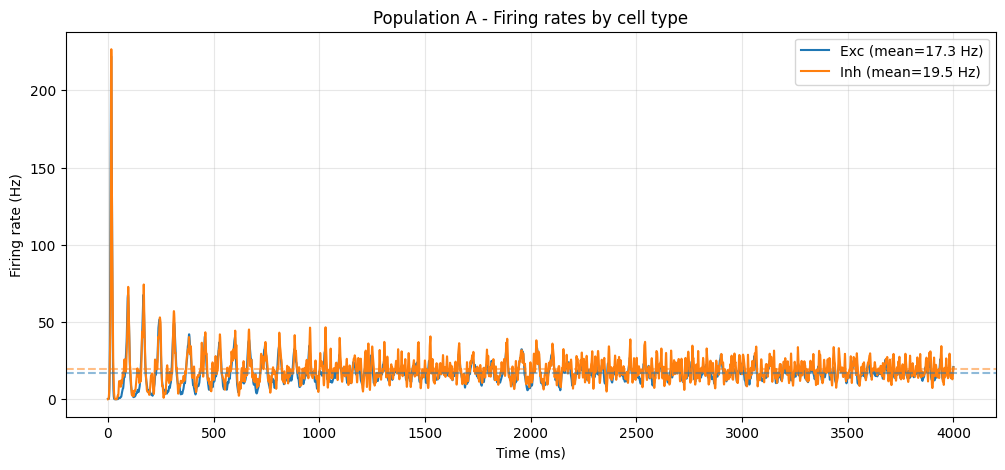

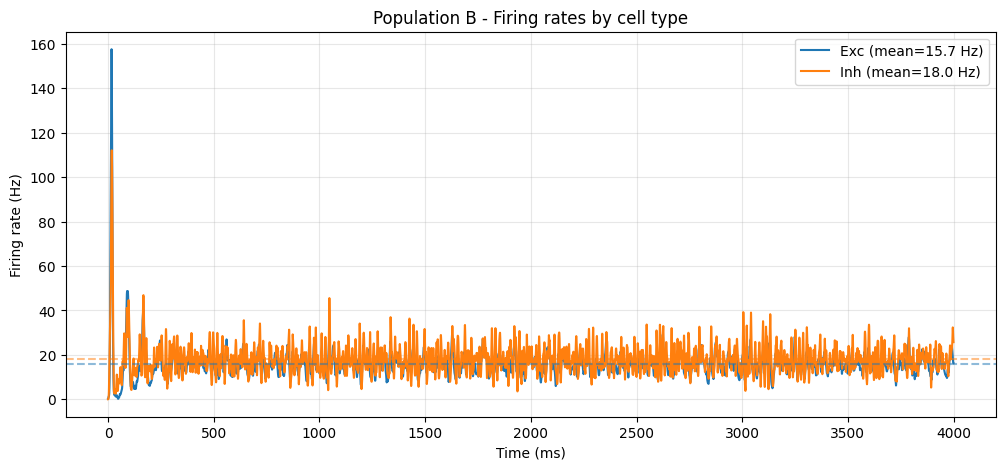

In [ ]:
def plot_firing_rates_by_type(results, pop_name='A', figsize=(12, 5)):
    """Firing rate temporal separando Exc/Inh"""
    
    spike_mon = results[pop_name]['spike_monitor']
    T_total = results['T_total']
    Ne = results[pop_name].get('Ne', 800)
    Ni = results[pop_name].get('Ni', 200)
    
    # Separar spikes
    exc_mask = spike_mon.i < Ne
    inh_mask = spike_mon.i >= Ne
    
    spike_times_exc = np.array(spike_mon.t[exc_mask] / ms)
    spike_times_inh = np.array(spike_mon.t[inh_mask] / ms)
    
    # Calcular rates
    dt = 0.5  # ms, bin size
    bins = np.arange(0, T_total + dt, dt)
    
    counts_exc, _ = np.histogram(spike_times_exc, bins=bins)
    counts_inh, _ = np.histogram(spike_times_inh, bins=bins)
    
    rate_exc = counts_exc / (dt/1000) / Ne  # Hz
    rate_inh = counts_inh / (dt/1000) / Ni
    
    # Suavizar
    from scipy.ndimage import gaussian_filter1d
    rate_exc_smooth = gaussian_filter1d(rate_exc, sigma=3)
    rate_inh_smooth = gaussian_filter1d(rate_inh, sigma=3)
    
    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    time_axis = bins[:-1]
    
    ax.plot(time_axis, rate_exc_smooth, label=f'Exc (mean={rate_exc.mean():.1f} Hz)', 
            color='C0', linewidth=1.5)
    ax.plot(time_axis, rate_inh_smooth, label=f'Inh (mean={rate_inh.mean():.1f} Hz)', 
            color='C1', linewidth=1.5)
    
    ax.axhline(rate_exc.mean(), color='C0', linestyle='--', alpha=0.5)
    ax.axhline(rate_inh.mean(), color='C1', linestyle='--', alpha=0.5)
    
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Firing rate (Hz)')
    ax.set_title(f'Population {pop_name} - Firing rates by cell type')
    ax.legend()
    ax.grid(alpha=0.3)
    
    return fig, {'exc_mean': rate_exc.mean(), 'inh_mean': rate_inh.mean()}

# Uso
fig, stats = plot_firing_rates_by_type(results, 'A')
print(f"Pop A - Exc: {stats['exc_mean']:.2f} Hz, Inh: {stats['inh_mean']:.2f} Hz")

fig, stats = plot_firing_rates_by_type(results, 'B')
print(f"Pop B - Exc: {stats['exc_mean']:.2f} Hz, Inh: {stats['inh_mean']:.2f} Hz")

5.1127142857142855 7.033142857142857


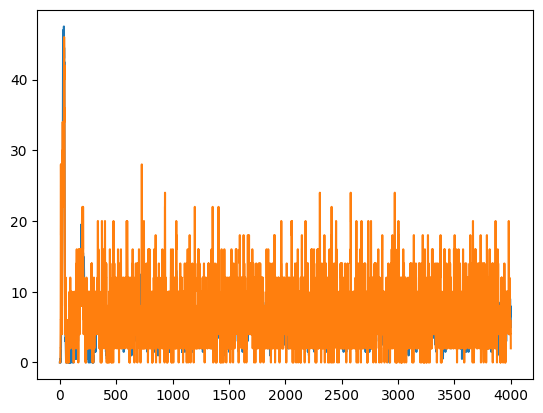

4.096214285714286 8.036857142857142


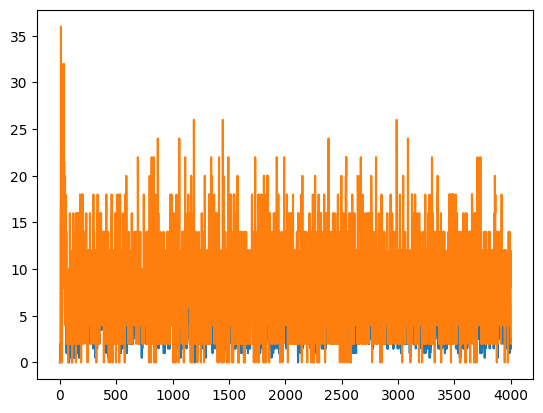

In [ ]:
def get_mean_fr_per_celltype(results, pop, cell_type='I'):
    
    spike_monitor = results[pop]['spike_monitor']
        
    if cell_type == 'E':
        time_monitor = spike_monitor.t[spike_monitor.i <= 800]
        
    else:
        
        time_monitor = spike_monitor.t[spike_monitor.i > 800]


    spike_times = np.array(time_monitor/ms)

    T_total = 4000
    analysis_dt = 0.5
    smooth_window = 5
    N_neurons = 800 if cell_type == 'E' else 200

    if len(spike_times) == 0:
        max_time = T_total if T_total else 1000  # Default si no hay spikes
    else:
        max_time = T_total if T_total else np.max(spike_times)

    time_bins = np.arange(0, max_time + analysis_dt, analysis_dt)

    spike_counts, _ = np.histogram(spike_times, bins=time_bins)
    population_rate = spike_counts / (analysis_dt/1000) / N_neurons

    if smooth_window > 1:
        kernel = np.ones(smooth_window) / smooth_window
        population_rate = np.convolve(population_rate, kernel, mode='same')


    plt.plot(time_bins[:-1], np.nan_to_num(population_rate, nan=0.0, posinf=0.0, neginf=0.0))
    return np.mean(np.nan_to_num(population_rate, nan=0.0, posinf=0.0, neginf=0.0)[1000:])

print(get_mean_fr_per_celltype(results, 'A' , 'E'), get_mean_fr_per_celltype(results, 'A' , 'I'))
plt.show()
print(get_mean_fr_per_celltype(results, 'B' , 'E'), get_mean_fr_per_celltype(results, 'B' , 'I'))

In [ ]:
results.keys()

dict_keys(['A', 'B', 'dt', 'T_total', 'seed_summary', 'delays_AB'])

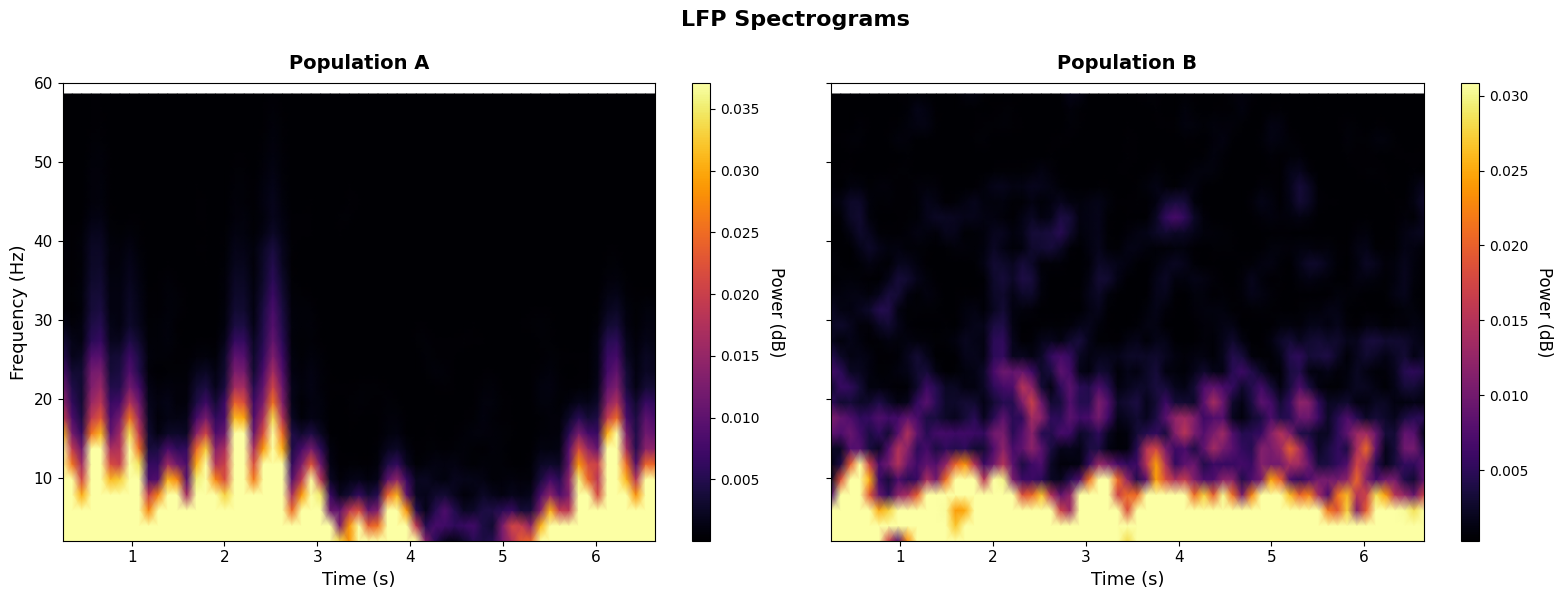

In [ ]:
from src.two_populations.plots.dashboard_plots import plot_spectrogram

figure = plot_spectrogram(results_dict)

WARNING    /tmp/ipykernel_195628/1201135731.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]


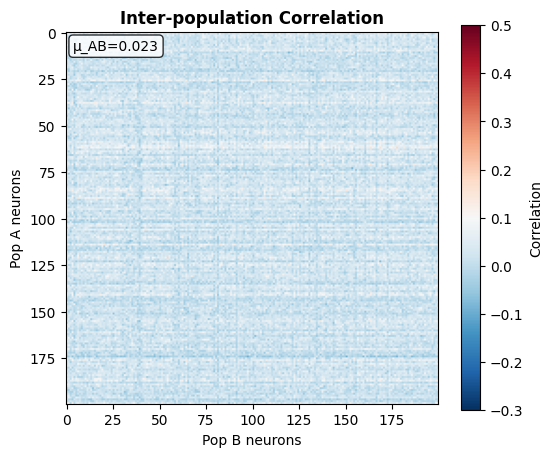

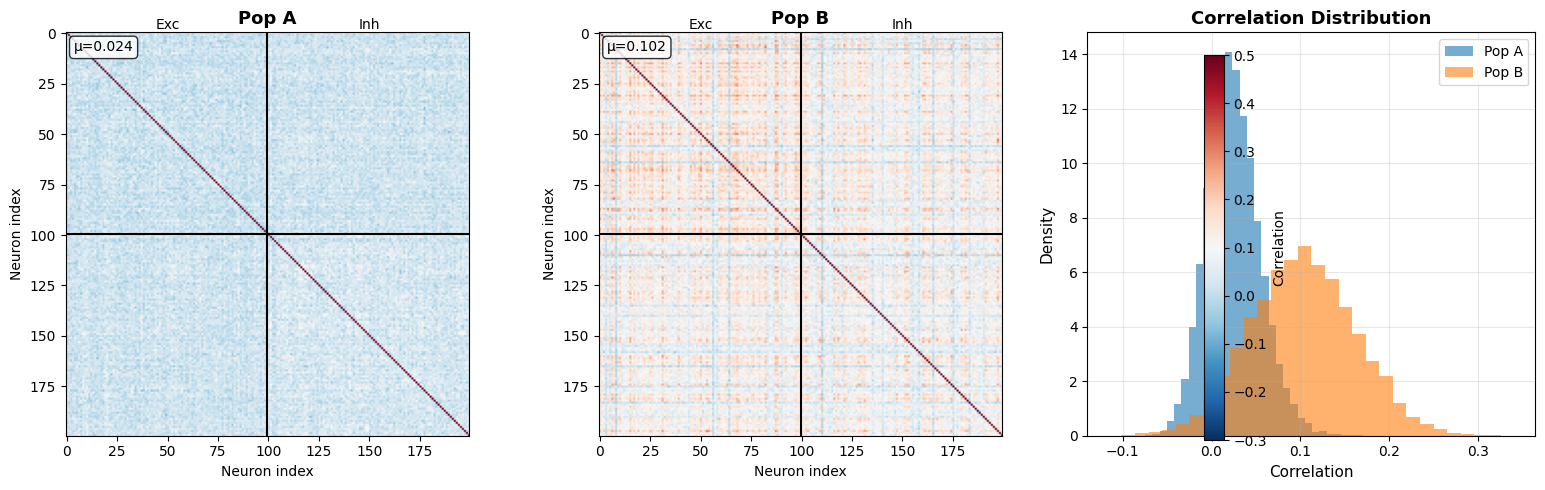

In [ ]:
def compute_correlation_matrix(voltage_monitor, neuron_indices, warmup_idx):
    """Correlación Pearson entre pares de neuronas"""
    V = voltage_monitor.v[:, warmup_idx:]  # [neurons, time]
    V_sample = V[neuron_indices, :]
    
    # Pearson correlation matrix
    corr_matrix = np.corrcoef(V_sample)
    
    return corr_matrix

def plot_correlation_matrix(results, n_sample=50):
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    N_monitored = 500  # 400 Exc + 100 Inh
    N_exc_mon = 400
    N_inh_mon = 100
    
    for idx, pop in enumerate(['A', 'B']):
        v_mon = results[pop]['voltage_monitor']
        
        # Sample de neuronas MONITORIZADAS
        sample_exc = np.random.choice(N_exc_mon, n_sample//2, replace=False)
        sample_inh = N_exc_mon + np.random.choice(N_inh_mon, n_sample//2, replace=False)
        sample = np.concatenate([sample_exc, sample_inh])
        
        corr = compute_correlation_matrix(v_mon, sample, warmup_idx=500)
        
        # Matriz
        im = axes[idx].imshow(corr, cmap='RdBu_r', vmin=-0.3, vmax=0.5)
        axes[idx].set_title(f'Pop {pop}', fontsize=13, weight='bold')
        axes[idx].axhline(n_sample//2-0.5, color='k', lw=1.5)
        axes[idx].axvline(n_sample//2-0.5, color='k', lw=1.5)
        axes[idx].set_xlabel('Neuron index')
        axes[idx].set_ylabel('Neuron index')
        
        # Labels E/I
        axes[idx].text(n_sample//4, -2, 'Exc', ha='center', fontsize=10)
        axes[idx].text(3*n_sample//4, -2, 'Inh', ha='center', fontsize=10)
        
        # Estadísticos (off-diagonal)
        mask = ~np.eye(corr.shape[0], dtype=bool)
        mean_corr = np.mean(corr[mask])
        axes[idx].text(0.02, 0.98, f'μ={mean_corr:.3f}', 
                      transform=axes[idx].transAxes, va='top',
                      bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 3) Histograma combinado
    ax_hist = axes[2]
    for idx, pop in enumerate(['A', 'B']):
        v_mon = results[pop]['voltage_monitor']
        Ne = 400
        sample_exc = np.random.choice(Ne, n_sample//2, replace=False)
        sample_inh = Ne + np.random.choice(Ne//4, n_sample//2, replace=False)
        sample = np.concatenate([sample_exc, sample_inh])
        corr = compute_correlation_matrix(v_mon, sample, 500)
        
        mask = ~np.eye(corr.shape[0], dtype=bool)
        ax_hist.hist(corr[mask].flatten(), bins=30, alpha=0.6, 
                    label=f'Pop {pop}', density=True)
    
    ax_hist.set_xlabel('Correlation', fontsize=11)
    ax_hist.set_ylabel('Density', fontsize=11)
    ax_hist.set_title('Correlation Distribution', fontsize=13, weight='bold')
    ax_hist.legend()
    ax_hist.grid(True, alpha=0.3)
    
    plt.colorbar(im, ax=axes, label='Correlation')
    plt.tight_layout()
    return fig

def plot_interpop_correlation(results, n_sample=30):
    fig, ax = plt.subplots(figsize=(6, 5))
    
    N_exc_mon = 400
    
    # Sample de monitorizadas
    sample_A = np.random.choice(N_exc_mon, n_sample, replace=False)
    sample_B = np.random.choice(N_exc_mon, n_sample, replace=False)
    
    V_A = results['A']['voltage_monitor'].v[sample_A, 500:]
    V_B = results['B']['voltage_monitor'].v[sample_B, 500:]
    
    # Correlación cruzada
    corr_AB = np.corrcoef(V_A, V_B)[:n_sample, n_sample:]
    
    im = ax.imshow(corr_AB, cmap='RdBu_r', vmin=-0.3, vmax=0.5)
    ax.set_xlabel('Pop B neurons')
    ax.set_ylabel('Pop A neurons')
    ax.set_title('Inter-population Correlation', weight='bold')
    plt.colorbar(im, label='Correlation')
    
    mean_cross = np.mean(corr_AB)
    ax.text(0.02, 0.98, f'μ_AB={mean_cross:.3f}', 
           transform=ax.transAxes, va='top',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    return fig

fig = plot_interpop_correlation(results, 200)

fig = plot_correlation_matrix(results, 200)

In [ ]:
# En src/two_populations/metrics.py

import numpy as np
from scipy.signal import hilbert, correlate, spectrogram
from scipy.stats import entropy

# ============= LFP & PHASE =============

def extract_lfp(V_monitor, start_ms, dt):
    """Extract LFP as mean membrane potential"""
    start_idx = int(start_ms / dt)
    V_matrix = V_monitor.v[:, start_idx:]  # mV ya debe estar
    lfp = np.mean(V_matrix, axis=0)
    return lfp

def compute_instantaneous_phase(signal, fs, freq_band=(40, 70)):
    """Hilbert transform for phase"""
    from scipy.signal import butter, filtfilt
    
    # Bandpass filter
    nyq = 0.5 * fs
    low, high = freq_band[0]/nyq, freq_band[1]/nyq
    b, a = butter(4, [low, high], btype='band')
    filtered = filtfilt(b, a, signal)
    
    # Phase via Hilbert
    analytic = hilbert(filtered)
    phase = np.angle(analytic)  # [-π, π]
    return phase

# ============= ROUTING STATES =============

def routing_state_analysis(lfp_A, lfp_B, fs, freq_band=(40, 70)):
    """
    Compute routing states from phase relationships.
    Returns fractions of time in Top/Bottom states and switch rate.
    """
    # Instantaneous phases
    phase_A = compute_instantaneous_phase(lfp_A, fs, freq_band)
    phase_B = compute_instantaneous_phase(lfp_B, fs, freq_band)
    
    # Relative phase [0, 1]
    delta_phi = ((phase_B - phase_A) % (2*np.pi)) / (2*np.pi)
    
    # States: Top (Y leads, 0 < ΔΦ < 0.5), Bottom (X leads, 0.5 < ΔΦ < 1)
    is_top_state = delta_phi < 0.5
    top_fraction = np.mean(is_top_state)
    
    # Switch rate (transitions per second)
    state_binary = is_top_state.astype(int)
    transitions = np.abs(np.diff(state_binary))
    dt = 1.0 / fs
    switch_rate_hz = np.sum(transitions) / (len(transitions) * dt)
    
    # Bimodality (peaks at ΔΦ↑* and ΔΦ↓*)
    hist, bins = np.histogram(delta_phi, bins=50, range=(0, 1))
    bimodality = np.std(hist) / np.mean(hist)  # Simple index
    
    return {
        'delta_phi': delta_phi,
        'top_state_fraction': top_fraction,
        'bottom_state_fraction': 1 - top_fraction,
        'switch_rate_hz': switch_rate_hz,
        'phase_bimodality': bimodality
    }

# ============= TRANSFER ENTROPY =============

def transfer_entropy_simple(source, target, lag=1, bins=50):
    """
    Simplified TE: H[Y_t | Y_{t-lag}] - H[Y_t | X_{t-lag}, Y_{t-lag}]
    Uses histogram-based entropy estimation.
    """
    # Prepare time series
    y_t = target[lag:]
    y_past = target[:-lag]
    x_past = source[:-lag]
    
    # Discretize
    def digitize(x):
        return np.digitize(x, bins=np.linspace(x.min(), x.max(), bins))
    
    y_t_d = digitize(y_t)
    y_past_d = digitize(y_past)
    x_past_d = digitize(x_past)
    
    # Joint distributions
    def joint_entropy(x, y):
        xy = np.column_stack([x, y])
        return entropy(np.histogram2d(x, y, bins=bins)[0].flatten())
    
    # H[Y_t, Y_{t-lag}]
    h_y_joint = joint_entropy(y_t_d, y_past_d)
    # H[Y_{t-lag}]
    h_y_past = entropy(np.histogram(y_past_d, bins=bins)[0])
    # H[Y_t, Y_{t-lag}, X_{t-lag}]
    h_full = entropy(np.histogramdd(np.column_stack([y_t_d, y_past_d, x_past_d]), bins=bins)[0].flatten())
    # H[Y_{t-lag}, X_{t-lag}]
    h_cond = joint_entropy(y_past_d, x_past_d)
    
    # TE = H[Y_t | Y_{t-lag}] - H[Y_t | X_{t-lag}, Y_{t-lag}]
    te = (h_y_joint - h_y_past) - (h_full - h_cond)
    return max(0, te)  # TE >= 0

def compute_bidirectional_te(lfp_A, lfp_B, max_lag_ms=20, dt=0.1):
    """TE in both directions over lag range"""
    max_lag_samples = int(max_lag_ms / dt)
    lags = np.arange(1, max_lag_samples)
    
    te_AB = [transfer_entropy_simple(lfp_A, lfp_B, lag) for lag in lags]
    te_BA = [transfer_entropy_simple(lfp_B, lfp_A, lag) for lag in lags]
    
    # Optimal lags
    tau_opt_AB = lags[np.argmax(te_AB)] * dt
    tau_opt_BA = lags[np.argmax(te_BA)] * dt
    
    # Anisotropy
    max_te_AB, max_te_BA = np.max(te_AB), np.max(te_BA)
    delta_te = (max_te_BA - max_te_AB) / max(abs(max_te_AB), abs(max_te_BA))
    
    return {
        'te_AB': te_AB,
        'te_BA': te_BA,
        'tau_opt_AB_ms': tau_opt_AB,
        'tau_opt_BA_ms': tau_opt_BA,
        'delta_te': delta_te,
        'lags_ms': lags * dt
    }

# ============= BURST DETECTION =============

def detect_gamma_bursts(lfp, fs, freq_range=(40, 70), percentile=95):
    """Detect transient gamma bursts via spectrogram thresholding"""
    signal_duration = len(lfp) / fs
    
    # Adaptar ventanas a longitud de señal
    if signal_duration < 1.0:
        # Señal corta: ventanas más pequeñas
        nperseg = max(int(0.1 * fs), 128)  # 100ms o mínimo
        noverlap = int(0.75 * nperseg)  # 75% overlap
    else:
        # Señal larga: ventanas del paper
        nperseg = int(0.3 * fs)  # 300ms
        noverlap = int(0.25 * fs)  # 250ms overlap
    
    f, t, Sxx = spectrogram(lfp, fs=fs, nperseg=nperseg, noverlap=noverlap)
    
    # Filter gamma band
    mask = (f >= freq_range[0]) & (f <= freq_range[1])
    Sxx_gamma = Sxx[mask, :]
    f_gamma = f[mask]
    
    # Skip si muy pocos time bins
    if Sxx_gamma.shape[1] < 3:
        return {
            'freqs': f_gamma,
            'times': t,
            'bursts': np.zeros_like(Sxx_gamma, dtype=bool),
            'power': Sxx_gamma
        }
    
    # Threshold per frequency
    burst_binary = np.zeros_like(Sxx_gamma, dtype=bool)
    for i in range(len(f_gamma)):
        thresh = np.percentile(Sxx_gamma[i, :], percentile)
        burst_binary[i, :] = Sxx_gamma[i, :] > thresh
    
    return {
        'freqs': f_gamma,
        'times': t,
        'bursts': burst_binary,
        'power': Sxx_gamma
    }

def compute_burst_overlap(bursts_A, bursts_B):
    """Jaccard-like overlap con protección"""
    n_A = np.sum(bursts_A, axis=1)
    n_B = np.sum(bursts_B, axis=1)
    n_both = np.sum(bursts_A & bursts_B, axis=1)
    
    # Evitar divisiones por 0
    denominator = np.sqrt(n_A * n_B)
    overlap = np.divide(n_both, denominator, 
                    out=np.zeros_like(n_both, dtype=float),
                    where=denominator > 1)  # Solo si >1 burst
    
    return overlap

# XC normalizado por ventana
def compute_xc_timeresolved(lfp_A, lfp_B, fs, window_ms=50, step_ms=10):
    window = int(window_ms * fs / 1000)
    step = int(step_ms * fs / 1000)
    max_lag_samples = int(20 * fs / 1000)
    
    n_windows = (len(lfp_A) - window) // step
    xc_matrix = np.zeros((2*max_lag_samples+1, n_windows))
    
    for i in range(n_windows):
        start = i * step
        chunk_A = lfp_A[start:start+window]
        chunk_B = lfp_B[start:start+window]
        
        # Normalizar chunks
        chunk_A = (chunk_A - chunk_A.mean()) / (chunk_A.std() + 1e-10)
        chunk_B = (chunk_B - chunk_B.mean()) / (chunk_B.std() + 1e-10)
        
        xc_full = correlate(chunk_A, chunk_B, mode='full')
        
        # Normalizar XC por longitud ventana
        xc_full = xc_full / window
        
        center = len(xc_full) // 2
        xc_matrix[:, i] = xc_full[center-max_lag_samples:center+max_lag_samples+1]
    
    return xc_matrix, np.arange(n_windows)*step_ms/1000

# ============= WRAPPER =============

def palmigiano_analysis(results, start_ms=500):
    """
    Complete analysis inspired by Palmigiano et al.
    Add to existing analyze_simulation_results.
    """
    dt = results['dt']
    fs = 1000.0 / dt
    
    # Extract LFPs
    lfp_A = extract_lfp(results['A']['voltage_monitor'], start_ms, dt)
    lfp_B = extract_lfp(results['B']['voltage_monitor'], start_ms, dt)
    
    metrics = {}
    
    # Routing states
    routing = routing_state_analysis(lfp_A, lfp_B, fs)
    metrics['routing'] = routing
    
    # Transfer Entropy
    te = compute_bidirectional_te(lfp_A, lfp_B, max_lag_ms=20, dt=dt)
    metrics['transfer_entropy'] = te
    
    # Burst coordination
    bursts_A = detect_gamma_bursts(lfp_A, fs)
    bursts_B = detect_gamma_bursts(lfp_B, fs)
    overlap = compute_burst_overlap(bursts_A['bursts'], bursts_B['bursts'])
    
    metrics['bursts'] = {
        'overlap': overlap,
        'peak_overlap': np.max(overlap),
        'peak_frequency': bursts_A['freqs'][np.argmax(overlap)],
        'A': bursts_A,
        'B': bursts_B
    }
    
    # XC time-resolved
    xc_matrix, xc_times = compute_xc_timeresolved(lfp_A, lfp_B, fs)
    xc_star = np.max(xc_matrix, axis=0)  # Max por ventana
    
    # Conditional phase

    from scipy.interpolate import interp1d
    time_lfp = np.arange(len(routing['delta_phi'])) / fs
    interp_func = interp1d(xc_times, xc_star, kind='linear', 
                        fill_value='extrapolate')
    xc_star_interp = interp_func(time_lfp)

    # Usar interpolado para máscaras
    thresh_low = np.percentile(xc_star_interp, 50)
    thresh_high = np.percentile(xc_star_interp, 50)

    metrics['xc_resolved'] = {
        'matrix': xc_matrix,
        'times': xc_times,
        'xc_star': xc_star,
        'delta_phi_low': routing['delta_phi'][xc_star_interp < thresh_low],
        'delta_phi_high': routing['delta_phi'][xc_star_interp > thresh_high]
    }
    
    return metrics

palmi_metrics = palmigiano_analysis(results, start_ms=500)

palmi_metrics.keys()

dict_keys(['routing', 'transfer_entropy', 'bursts', 'xc_resolved'])

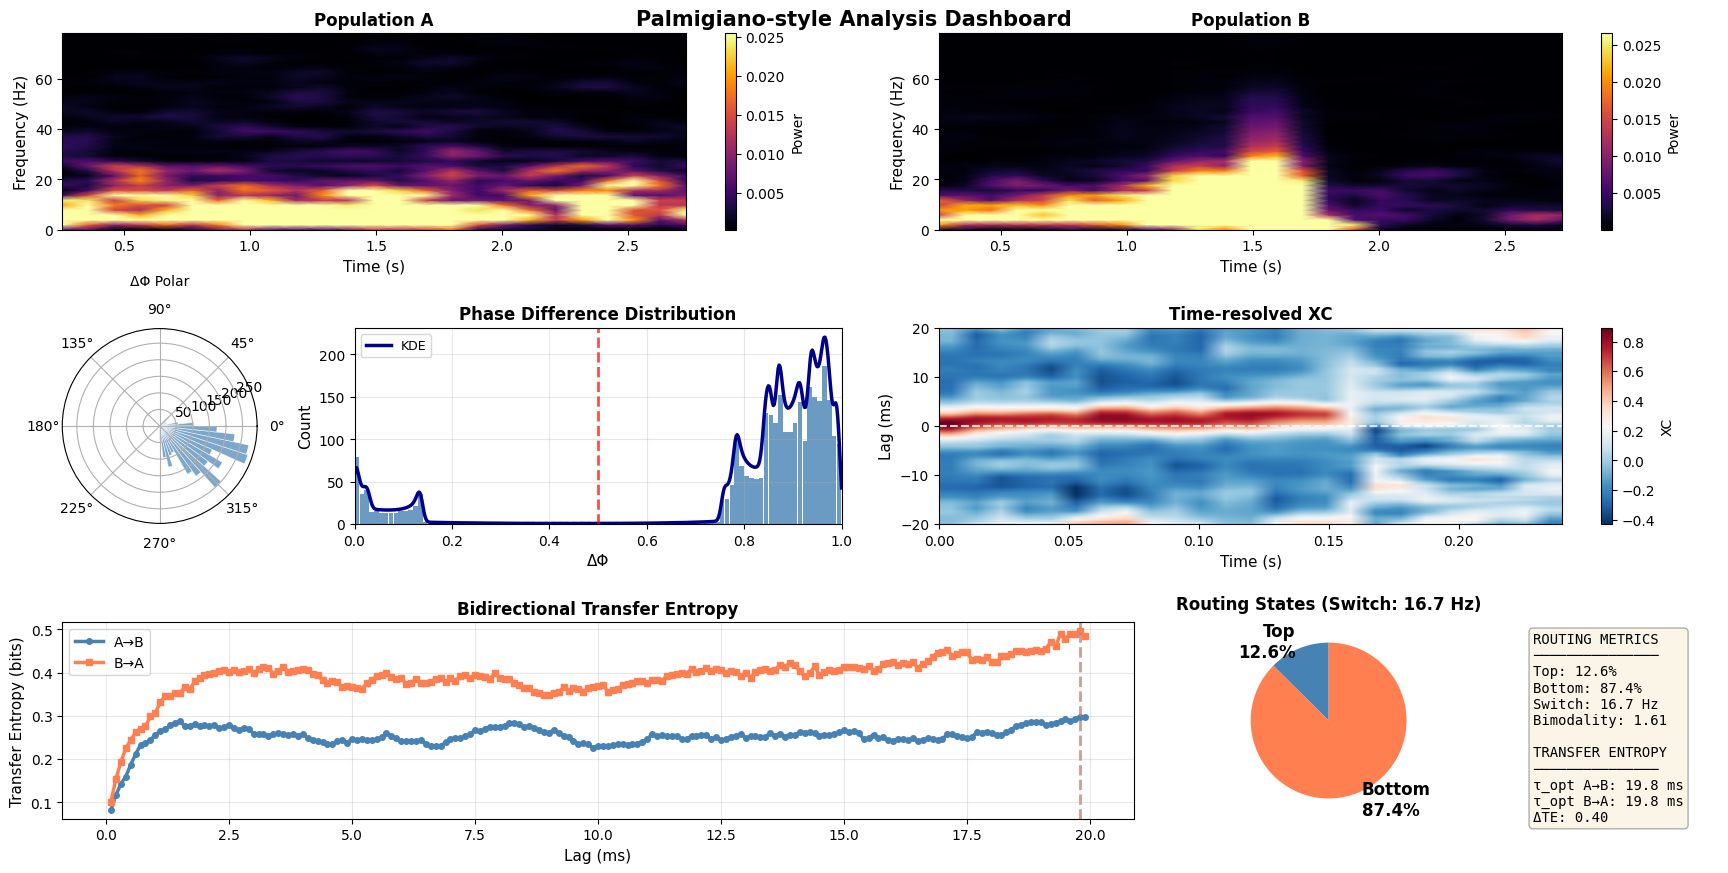

<Figure size 640x480 with 0 Axes>

In [ ]:
# src/two_populations/plots/dashboard_plots.py

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
from scipy.ndimage import gaussian_filter
from scipy.signal import spectrogram
from scipy.stats import gaussian_kde

def plot_palmigiano_dashboard(palmi_metrics, lfp_A, lfp_B, fs, save_path=None):
    """Palmigiano dashboard - optimized layout"""
    
    fig = plt.figure(figsize=(18, 12))
    gs = GridSpec(4, 6, figure=fig, hspace=0.5, wspace=0.5,
                  top=0.95, bottom=0.05, left=0.06, right=0.98)
    
    # ========== Row 1: Spectrograms ==========
    for idx, (lfp, label) in enumerate([(lfp_A, 'A'), (lfp_B, 'B')]):
        ax = fig.add_subplot(gs[0, idx*3:(idx+1)*3])
        
        nperseg = 512
        noverlap = int(nperseg * 0.8)
        lfp_proc = (lfp - np.mean(lfp)) / (np.std(lfp) + 1e-10)
        
        f, t, Sxx = spectrogram(lfp_proc, fs=1000, nperseg=nperseg, 
                                noverlap=noverlap, window='hann', scaling='density')
        
        mask = f <= 80
        f_masked = f[mask]
        Sxx_smooth = gaussian_filter(Sxx[mask, :], sigma=(0.5, 0.5))
        
        vmin, vmax = np.percentile(Sxx_smooth, [10, 90])
        
        im = ax.pcolormesh(t, f_masked, Sxx_smooth, shading='gouraud',
                          cmap='inferno', vmin=vmin, vmax=vmax, rasterized=True)
        ax.set_ylabel('Frequency (Hz)', fontsize=11)
        ax.set_xlabel('Time (s)', fontsize=11)
        ax.set_title(f'Population {label}', fontsize=12, weight='bold')
        plt.colorbar(im, ax=ax, label='Power', aspect=18)
    
    # ========== Row 2: Phase Distribution + XC Heatmap ==========
    delta_phi = palmi_metrics['routing']['delta_phi']
    xc_data = palmi_metrics['xc_resolved']
    
    # Polar 
    ax_polar = fig.add_subplot(gs[1, 0], projection='polar')
    ax_polar.hist(delta_phi * 2*np.pi, bins=60, density=False,
                  color='steelblue', alpha=0.7, edgecolor='white', linewidth=0.5)
    ax_polar.set_title('ΔΦ Polar', pad=12, fontsize=10)
    
    # Linear histogram (2 columns)
    ax_phase = fig.add_subplot(gs[1, 1:3])
    counts, bins = np.histogram(delta_phi, bins=100)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    ax_phase.bar(bin_centers, counts, width=np.diff(bins)[0]*0.95,
                 color='steelblue', alpha=0.8, edgecolor='none')
    
    if len(delta_phi) > 10:
        kde = gaussian_kde(delta_phi, bw_method=0.02)
        x_smooth = np.linspace(0, 1, 500)
        kde_scaled = kde(x_smooth) * len(delta_phi) / 80
        ax_phase.plot(x_smooth, kde_scaled, 'darkblue', linewidth=2.5, label='KDE')
    
    ax_phase.axvline(0.5, color='red', linestyle='--', alpha=0.7, linewidth=2)
    ax_phase.set_xlim([0, 1])
    ax_phase.set_xlabel('ΔΦ', fontsize=11)
    ax_phase.set_ylabel('Count', fontsize=11)
    ax_phase.set_title('Phase Difference Distribution', fontsize=12, weight='bold')
    ax_phase.legend(fontsize=9)
    ax_phase.grid(alpha=0.3)
    
    # XC heatmap (3 columns)
    ax_xc = fig.add_subplot(gs[1, 3:])
    lags_ms = np.linspace(-20, 20, xc_data['matrix'].shape[0])
    im = ax_xc.imshow(xc_data['matrix'], aspect='auto', cmap='RdBu_r',
                      extent=[0, xc_data['times'][-1], lags_ms[0], lags_ms[-1]],
                      interpolation='bilinear')
    ax_xc.axhline(0, color='white', linestyle='--', linewidth=1.5, alpha=0.8)
    ax_xc.set_xlabel('Time (s)', fontsize=11)
    ax_xc.set_ylabel('Lag (ms)', fontsize=11)
    ax_xc.set_title('Time-resolved XC', fontsize=12, weight='bold')
    plt.colorbar(im, ax=ax_xc, label='XC', aspect=18)
    
    # ========== Row 3: Transfer Entropy (4 columns, más espacio) ==========
    te_data = palmi_metrics['transfer_entropy']
    ax_te = fig.add_subplot(gs[2, :4])
    
    ax_te.plot(te_data['lags_ms'], te_data['te_AB'], 'o-', 
               label='A→B', color='steelblue', markersize=4, linewidth=2.5)
    ax_te.plot(te_data['lags_ms'], te_data['te_BA'], 's-', 
               label='B→A', color='coral', markersize=4, linewidth=2.5)
    ax_te.axvline(te_data['tau_opt_AB_ms'], color='steelblue', 
                  linestyle='--', alpha=0.5, linewidth=2)
    ax_te.axvline(te_data['tau_opt_BA_ms'], color='coral', 
                  linestyle='--', alpha=0.5, linewidth=2)
    ax_te.set_xlabel('Lag (ms)', fontsize=11)
    ax_te.set_ylabel('Transfer Entropy (bits)', fontsize=11)
    ax_te.set_title('Bidirectional Transfer Entropy', fontsize=12, weight='bold')
    ax_te.legend(fontsize=10, frameon=True, loc='upper left')
    ax_te.grid(alpha=0.3)
    
    # ========== Row 3: Summary (pegado a la derecha) ==========
    routing = palmi_metrics['routing']
    ax_summary = fig.add_subplot(gs[2, 5:])
    ax_summary.axis('off')
    
    summary_text = f"""ROUTING METRICS
───────────────
Top: {routing['top_state_fraction']:.1%}
Bottom: {routing['bottom_state_fraction']:.1%}
Switch: {routing['switch_rate_hz']:.1f} Hz
Bimodality: {routing['phase_bimodality']:.2f}

TRANSFER ENTROPY
───────────────
τ_opt A→B: {te_data['tau_opt_AB_ms']:.1f} ms
τ_opt B→A: {te_data['tau_opt_BA_ms']:.1f} ms
ΔTE: {te_data['delta_te']:.2f}"""
    
    ax_summary.text(0.05, 0.95, summary_text, transform=ax_summary.transAxes,
                    fontsize=10, va='top', family='monospace',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    # ========== Row 4: Routing Pie (centrado, pegado con summary) ==========
    ax_routing = fig.add_subplot(gs[2, 4:5])
    fractions = [routing['top_state_fraction'], routing['bottom_state_fraction']]
    labels = [f'Top\n{fractions[0]:.1%}', f'Bottom\n{fractions[1]:.1%}']
    colors_pie = ['steelblue', 'coral']
    ax_routing.pie(fractions, labels=labels, colors=colors_pie, 
                   startangle=90, textprops={'fontsize': 12, 'weight': 'bold'})
    ax_routing.set_title(f'Routing States (Switch: {routing["switch_rate_hz"]:.1f} Hz)', 
                        fontsize=12, weight='bold', pad=10)
    
    plt.suptitle('Palmigiano-style Analysis Dashboard', 
                 fontsize=15, fontweight='bold', y=0.97)
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.close()
        
    plt.tight_layout()
    
    return fig

# En sweep o notebook
palmi_metrics = palmigiano_analysis(results)
lfp_A = extract_lfp(results['A']['voltage_monitor'], 500, results['dt'])
lfp_B = extract_lfp(results['B']['voltage_monitor'], 500, results['dt'])

plot_palmigiano_dashboard(palmi_metrics, lfp_A, lfp_B, 
                                 fs=10000, save_path='results/palmigiano_dash.png')

In [ ]:
print(f"ΔΦ range: [{delta_phi.min():.2f}, {delta_phi.max():.2f}]")
print(f"ΔΦ std: {delta_phi.std():.3f}")
print(f"N bursts A: {palmi_metrics['bursts']['A']['bursts'].sum()}")
print(f"N bursts B: {palmi_metrics['bursts']['B']['bursts'].sum()}")

NameError: name 'delta_phi' is not defined

In [ ]:
# Después de palmigiano_analysis
print(f"N total delta_phi: {len(palmi_metrics['routing']['delta_phi'])}")
print(f"N high XC: {len(palmi_metrics['xc_resolved']['delta_phi_high'])}")
print(f"N low XC: {len(palmi_metrics['xc_resolved']['delta_phi_low'])}")
print(f"Max burst overlap: {palmi_metrics['bursts']['peak_overlap']}")

N total delta_phi: 3000
N high XC: 1500
N low XC: 1500
Max burst overlap: 0.0


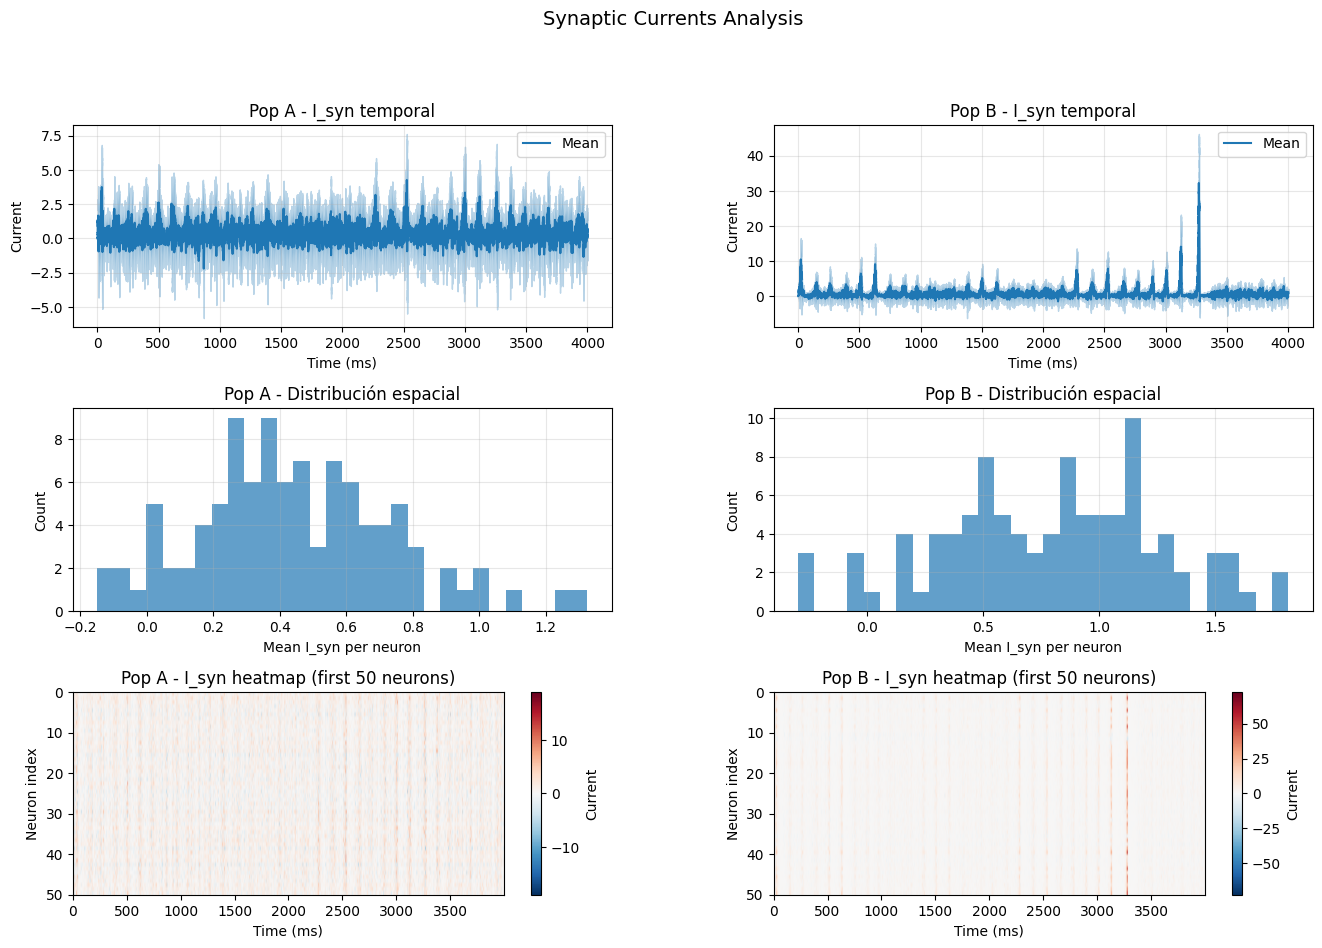

In [ ]:
from src.two_populations.plots.basic_plots import plot_synaptic_currents, plot_thalamic_drive

fig = plot_synaptic_currents(results_dict, results)

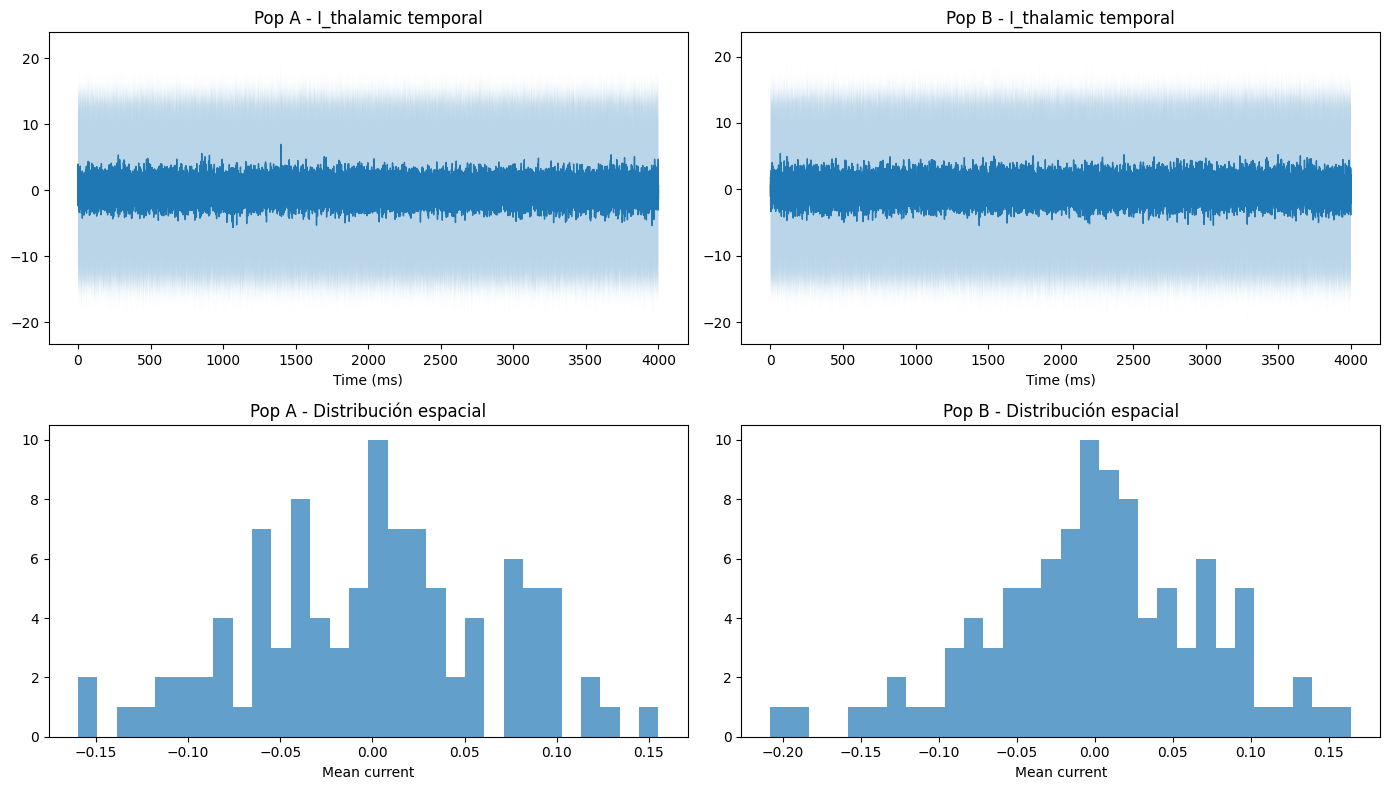

In [ ]:
fig = plot_thalamic_drive(results_dict, results)

INFO       Analyzing thalamic input modulation patterns... [brian2]
INFO       Input analysis complete: [brian2]
INFO         Time: 3500ms, dt: 0.1ms [brian2]
INFO         Excitatory modulation: 1.0 → 1.0 [brian2]
INFO         Inhibitory modulation: 1.0 → 1.2 [brian2]


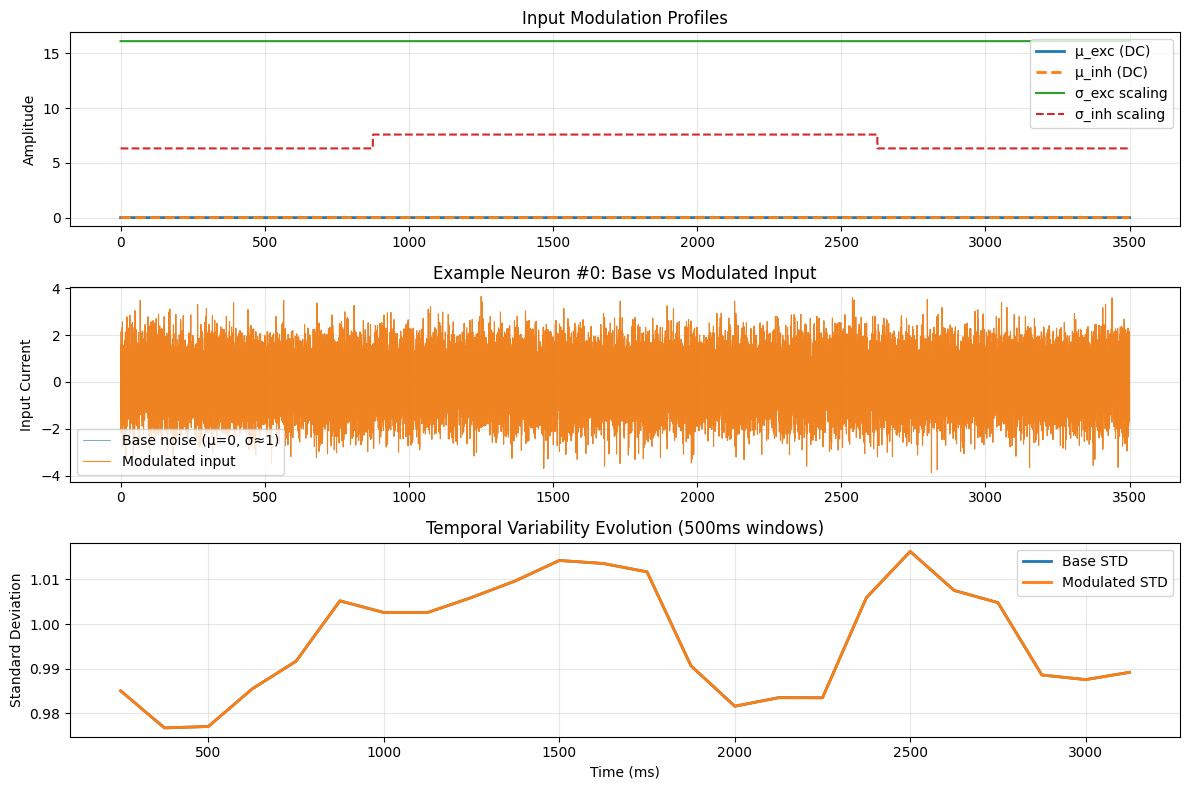

In [ ]:
# =============================================================================
# MODEL INPUT VALIDATION ANALYSIS (Optional)
# =============================================================================

def analyze_thalamic_input_modulation(time_ms=3500, dt_ms=0.1, n_neurons=800):
    """Analyze thalamic input modulation patterns used in the model"""
    
    logger.info("Analyzing thalamic input modulation patterns...")
    
    # Setup parameters matching model
    n_timesteps = int(time_ms / dt_ms)
    lambda_exc = 5.1**2 / dt_ms
    lambda_inh = 2.0**2 / dt_ms
    
    def step_profile(n, start=0.25, end=0.75, base=0.0, elev=1.0):
        prof = np.full(n, base, dtype=float)
        s, e = int(n*start), int(n*end)
        prof[s:e] = elev
        return prof
    
    # Current modulation profiles (simplified version)
    mu_exc = step_profile(n_timesteps, 0.25, 0.75, base=0.0, elev=0.0)
    sigma_exc = step_profile(n_timesteps, 0.25, 0.75, base=1.0, elev=1.0)
    mu_inh = step_profile(n_timesteps, 0.25, 0.75, base=0.0, elev=0.0)
    sigma_inh = step_profile(n_timesteps, 0.25, 0.75, base=1.0, elev=1.2)
    
    # Generate noise signals
    np.random.seed(42)  # For reproducibility
    z_exc = np.random.randn(n_timesteps, n_neurons)
    z_inh = np.random.randn(n_timesteps, n_neurons)
    
    I_exc = sigma_exc[:, None] * z_exc
    I_inh = sigma_inh[:, None] * z_inh
    
    # Analysis
    t = np.arange(n_timesteps) * dt_ms
    neuron = 0
    
    def rolling_std(x, window_ms=500):
        win = int(window_ms / dt_ms)
        hop = max(1, win//4)
        out_t, out = [], []
        for i in range(0, len(x)-win, hop):
            seg = x[i:i+win]
            out_t.append((i + win/2) * dt_ms)
            out.append(np.std(seg - seg.mean()))
        return np.array(out_t), np.array(out)
    
    # Generate visualization
    fig, axes = plt.subplots(3, 1, figsize=(12, 8))
    
    # Modulation profiles
    axes[0].plot(t, mu_exc, label='μ_exc (DC)', lw=2)
    axes[0].plot(t, mu_inh, label='μ_inh (DC)', lw=2, ls='--')
    axes[0].plot(t, sigma_exc*np.sqrt(lambda_exc), label='σ_exc scaling', lw=1.5)
    axes[0].plot(t, sigma_inh*np.sqrt(lambda_inh), label='σ_inh scaling', lw=1.5, ls='--')
    axes[0].set_title('Input Modulation Profiles')
    axes[0].set_ylabel('Amplitude')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()
    
    # Example neuron signals
    axes[1].plot(t, z_exc[:, neuron], lw=0.6, alpha=0.7, label='Base noise (μ=0, σ≈1)')
    axes[1].plot(t, I_exc[:, neuron], lw=0.8, alpha=0.9, label='Modulated input')
    axes[1].set_title(f'Example Neuron #{neuron}: Base vs Modulated Input')
    axes[1].set_ylabel('Input Current')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    
    # Temporal variability
    tb, std_base = rolling_std(z_exc[:, neuron])
    tm, std_mod = rolling_std(I_exc[:, neuron])
    axes[2].plot(tb, std_base, lw=2, label='Base STD')
    axes[2].plot(tm, std_mod, lw=2, label='Modulated STD')
    axes[2].set_title('Temporal Variability Evolution (500ms windows)')
    axes[2].set_xlabel('Time (ms)')
    axes[2].set_ylabel('Standard Deviation')
    axes[2].grid(True, alpha=0.3)
    axes[2].legend()
    
    plt.tight_layout()
    
    # Summary statistics
    logger.info(f"Input analysis complete:")
    logger.info(f"  Time: {time_ms}ms, dt: {dt_ms}ms")
    logger.info(f"  Excitatory modulation: {sigma_exc.min():.1f} → {sigma_exc.max():.1f}")
    logger.info(f"  Inhibitory modulation: {sigma_inh.min():.1f} → {sigma_inh.max():.1f}")
    
    return fig

# Run input validation analysis (uncomment to execute)
input_fig = analyze_thalamic_input_modulation()
plt.show()

INFO       Analyzing warmup: 0-2000ms... [brian2]
WARNING    /tmp/ipykernel_195628/3287978585.py:47: RuntimeWarning: All-NaN axis encountered
  logger.info(f"Range: {np.nanmin(cc_peaks):.3f} - {np.nanmax(cc_peaks):.3f}")
 [py.warnings]
INFO       Range: nan - nan [brian2]


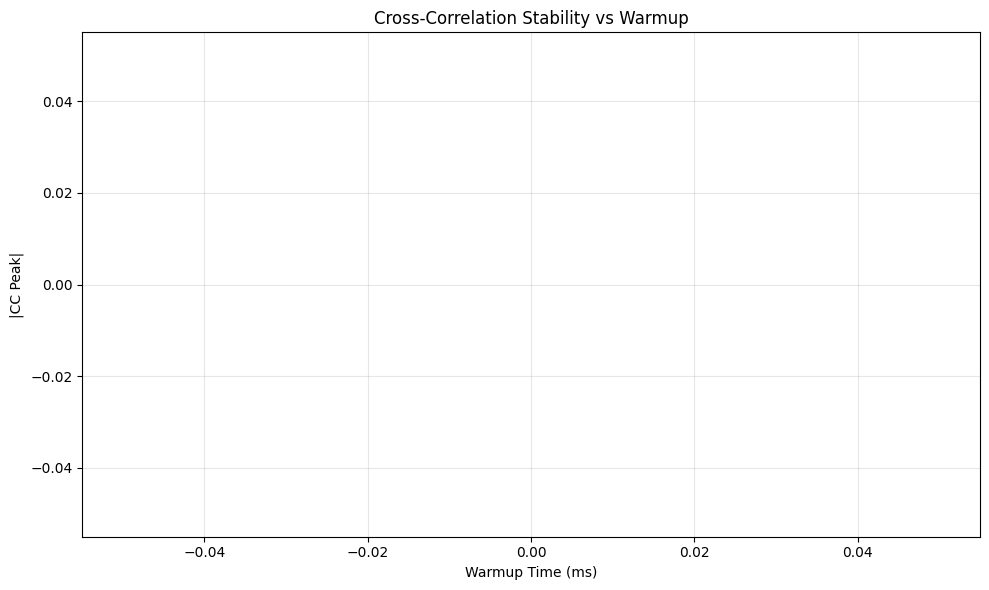

In [ ]:
# =============================================================================
# WARMUP TIME VALIDATION
# =============================================================================

def analyze_warmup_effects(raw_results, warmup_range=(0, 2500, 100)):
    """Analyze cross-correlation stability across warmup times"""
    
    from src.two_populations.metrics import analyze_simulation_results
    
    warmup_times = np.arange(*warmup_range)
    cc_peaks = []
    
    logger.info(f"Analyzing warmup: {warmup_range[0]}-{warmup_range[1]}ms...")
    
    for warmup in warmup_times:
        try:
            result = analyze_simulation_results(
                raw_results['A']['spike_monitor'],
                raw_results['B']['spike_monitor'],
                Ne + Ni, f"warmup_{warmup}ms", warmup=warmup,
                signal_mode = 'lfp'
            )
            cc_peaks.append(abs(result['cross_correlation']['peak_value']))
        except:
            cc_peaks.append(np.nan)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    valid = ~np.isnan(cc_peaks)
    ax.plot(warmup_times[valid], np.array(cc_peaks)[valid], 'o-', lw=2, ms=6)
    
    # Stable region
    stable_idx = (warmup_times >= 1000) & valid
    if np.any(stable_idx):
        stable_mean = np.mean(np.array(cc_peaks)[stable_idx])
        stable_std = np.std(np.array(cc_peaks)[stable_idx])
        ax.axhline(stable_mean, color='red', ls='--', alpha=0.7,
                  label=f'Stable: {stable_mean:.3f}±{stable_std:.3f}')
        ax.legend()
    
    ax.set_xlabel('Warmup Time (ms)')
    ax.set_ylabel('|CC Peak|')
    ax.set_title('Cross-Correlation Stability vs Warmup')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    
    logger.info(f"Range: {np.nanmin(cc_peaks):.3f} - {np.nanmax(cc_peaks):.3f}")
    if 'stable_mean' in locals():
        logger.info(f"Stable (>1s): {stable_mean:.3f}±{stable_std:.3f}")
    
    return fig

# Run
warmup_fig = analyze_warmup_effects(
    results, 
    warmup_range=(0, SIM_CONFIG['T_ms']//2, 100)  # Use SIM_CONFIG
)
plt.show()

In [ ]:
# Función para analizar resultados
def plot_two_population_results(results):
    """Graficar raster plots de ambas poblaciones"""
    
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    
    # Población A
    axes[0].plot(results['A']['spike_times'], results['A']['spike_indices'], 
                '.', markersize=0.5, color='black', alpha=0.7)
    axes[0].set_ylabel('Neurona A')
    axes[0].set_title(f'Red de Dos Poblaciones - dt = {results["dt"]} ms')
    axes[0].axhline(y=800, color='red', linestyle='--')
    
    # Población B
    axes[1].plot(results['B']['spike_times'], results['B']['spike_indices'], 
                '.', markersize=0.5, color='black')
    axes[1].set_ylabel('Neurona B')
    axes[1].set_xlabel('Tiempo (ms)')
    axes[1].axhline(y=800, color='red', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas
    logger.info(f"Spikes A: {len(results['A']['spike_times'])}")
    logger.info(f"Spikes B: {len(results['B']['spike_times'])}")
    logger.info(f"Rate A: {len(results['A']['spike_times'])/(results['T_total']*800)*1000:.2f} Hz")
    logger.info(f"Rate B: {len(results['B']['spike_times'])/(results['T_total']*800)*1000:.2f} Hz")

In [ ]:
# =============================================================================
# VALIDATION EXPERIMENTS SUITE
# =============================================================================
from src.two_populations.helpers.validator import add_validation_to_analysis, plot_population_validation_dashboard, print_validation_summary
from src.two_populations.model import IzhikevichNetwork
from src.two_populations.metrics import analyze_simulation_results
from src.two_populations.plots.dashboard_plots import plot_connectivity_dashboard, plot_population_dashboard

def run_validation_experiments():
    """
    Experimentos sistemáticos para validar comportamiento del modelo
    """
   
    
    results_dict = {}
    
    # Parámetros base
    k_factor = 3.5
    noise_int = 5.1
    noise_inh_factor = 0.451
    
    base_pop_params = {
        'Ne': 800, 'Ni': 200,
        'k_exc': k_factor*0.5, 'k_inh': k_factor*1.0,
        'noise_exc': noise_int, 'noise_inh': noise_int*noise_inh_factor,
        'p_intra': 0.1, 'delay': 0.5, 'noise_type': 'poisson'
    }
    
    experiments = [
        {
            'name': 'isolated',
            'desc': 'Poblaciones aisladas (sin conexión)',
            'connect': False,
            'expected': {'plv_alpha': '<0.2', 'cc_peak': '<0.3'}
        },
        {
            'name': 'weak_coupling - delta 5ms',
            'desc': 'Acoplamiento débil',
            'connect': True,
            'p_inter': 0.02,
            'weight_scale': k_factor*0.2,
            'delay': 5.0,
            'expected': {'plv_alpha': '0.2-0.4', 'cc_peak': '0.2-0.4'}
        },
        {
            'name': 'strong_coupling - delta 5ms',
            'desc': 'Acoplamiento fuerte',
            'connect': True,
            'p_inter': 0.02,
            'weight_scale': k_factor*2.0,
            'delay': 5.0,
            'expected': {'plv_alpha': '>0.5', 'cc_peak': '>0.4'}
        },
        {
            'name': 'zero_delay',
            'desc': 'Sin delay (control)',
            'connect': True,
            'p_inter': 0.02,
            'weight_scale': k_factor*1.0,
            'delay': 0.0,
            'expected': {'cc_lag': '<3ms'}
        }
    ]
    
    for exp in experiments:
        
        results_dict = {}
        
        logger.info(f"\n{'='*60}")
        logger.info(f"EXPERIMENTO: {exp['desc']}")
        logger.info(f"{'='*60}")
        
        # Create network
        net = IzhikevichNetwork(dt_val=0.1, T_total=4000, 
                               fixed_seed=100, variable_seed=200)
        
        # Populations
        net.create_population('A', **base_pop_params)
        net.create_population('B', **base_pop_params)
        
        # Connection
        if exp['connect']:
            net.connect_populations('A', 'B',
                p_inter=exp['p_inter'],
                weight_scale=exp['weight_scale'],
                delay_value=exp['delay'])
        
        # Run
        network.setup_monitors(['A', 'B'], record_v_dt=0.5, sample_fraction=0.5)
        results = net.run_simulation()
        
        # Analyze
        analysis = analyze_simulation_results(
            results['A']['spike_monitor'],
            results['B']['spike_monitor'],
            base_pop_params['Ne'] + base_pop_params['Ni'], exp['name'], warmup=500,
            state_monitors={
                'A': network.monitors['A'],  # pasar dict completo
                'B': network.monitors['B']
            },
            delays = {'AB': np.array(results['delays_AB']), 'BA': None},
            signal_mode = 'lfp'
        )

        results_dict[exp['name']] = analysis
        
        # Check expectations
        plv = analysis['plv_alpha']
        cc_peak = abs(analysis['cross_corr_peak'])
        cc_lag = abs(analysis['cross_corr_lag'])
        
        logger.info(f"Resultados:")
        logger.info(f"  PLV alpha: {plv:.3f} (expected: {exp['expected'].get('plv_alpha', 'N/A')})")
        logger.info(f"  CC peak: {cc_peak:.3f} (expected: {exp['expected'].get('cc_peak', 'N/A')})")
        logger.info(f"  CC lag: {cc_lag:.1f}ms (expected: {exp['expected'].get('cc_lag', 'N/A')})")
        
        # Add validation metrics
        validation_results = add_validation_to_analysis(results_dict)

        fig_val = plot_population_validation_dashboard(validation_results)
        print_validation_summary(validation_results)

        fig_conn = plot_connectivity_dashboard(results_dict, figsize=(20, 14))
        fig_pop = plot_population_dashboard(results_dict, figsize=(20, 14))
        plt.show()
    
    return results_dict

# Run validation suite
logger.info("Running validation experiments...")

results_dict = run_validation_experiments()

# # Add validation metrics
# validation_results = add_validation_to_analysis(results_dict)

# fig_val = plot_population_validation_dashboard(validation_results)
# print_validation_summary(validation_results)

# fig_conn = plot_connectivity_dashboard(results_dict, figsize=(20, 14))
# fig_pop = plot_population_dashboard(results_dict, figsize=(20, 14))
# plt.show()

INFO       Running validation experiments... [brian2]
INFO       
============================================================ [brian2]
INFO       EXPERIMENTO: Poblaciones aisladas (sin conexión) [brian2]
INFO       ============================================================ [brian2]
SUCCESS  | src.two_populations.model:__init__:44 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:create_population:166 - Intra-connectivity de  A: 79938 Exc, 20213 Inh synapses
INFO     | src.two_populations.model:create_population:166 - Intra-connectivity de  B: 80348 Exc, 20166 Inh synapses


KeyError: 'A'

In [ ]:
# Añadir ANTES del análisis en cada experimento:
logger.info(f"Spikes A: {len(results['A']['spike_times'])}")
logger.info(f"Spikes B: {len(results['B']['spike_times'])}")
logger.info(f"Spikes post-warmup A: {np.sum(results['A']['spike_times'] > 500)}")
logger.info(f"Spikes post-warmup B: {np.sum(results['B']['spike_times'] > 500)}")

In [ ]:
# Quick spike count check
for name, res in validation_results.items():
    logger.info(f"{name}: CC={res.get('cross_corr_peak', 'N/A')}, PLV={res.get('plv_alpha', 'N/A')}")